# 0.0 - Imports

In [1]:
import math
import datetime
import inflection

import numpy        as np
import pandas       as pd
import seaborn      as sns
import xgboost      as xgb

from scipy                 import stats                      as ss
from scipy                 import stats

from boruta                import BorutaPy

from matplotlib            import pyplot                     as plt
from matplotlib            import gridspec

from IPython.display       import Image
from IPython.core.display  import HTML

from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder


C:\Users\filip\anaconda3\envs\DSemProducao\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## 0.1 - Helper Function

In [2]:
def cramer_v (x, y):
    cm = pd.crosstab(x, y).values    
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))


def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
def cross_validation( model_name, model, x_training, kfold, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed ( range( 1,kfold+1 )):
        if verbose:
            print('\nKFold Number: {}'.format(k))

        # start and end of validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days = k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days = (k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) &
                                (x_training['date'] <= validation_end_date)     ]

        # training and validation dataset
        # training
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name , np.expm1(yvalidation), np.expm1(yhat))

        # storing fold performance
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])    
        rmse_list.append(m_result['RMSE'])    
    
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype(str) + ' +/- ' 
                                            + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype(str) + ' +/- ' 
                                            + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype(str) + ' +/- ' 
                                            + np.round( np.std( rmse_list ), 2 ).astype( str )}, index=[0] )

In [10]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 - Loading data

In [11]:
df_sales_raw = pd.read_csv('Data/train.csv', low_memory = False)
df_store_raw = pd.read_csv('Data/store.csv', low_memory = False)

#merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0 - Passo 1 - Data description

In [128]:
df1= df_raw.copy()

## 1.1 - Rename Columns

In [13]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map( snakecase, cols_old))

# rename
df1.columns = cols_new

## 1.2 - Data Dimention

In [14]:
print ('Number of rows: {}'.format(df1.shape[0]))
print ('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 1017209
Number of columns: 18


## 1.3 - Data Types

In [15]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 - Check NA

In [16]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 - Fillout NA

In [17]:
# competition_distance    
# to resolve the NA values in this column, we'll give all those lines a value far greater than the max value found in the DF
# therefore basically saying there is no competition nearby
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month 
                                                    if math.isnan(x['competition_open_since_month'])
                                                    else x['competition_open_since_month'], axis=1)

# competition_open_since_year 
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year 
                                                    if math.isnan(x['competition_open_since_year'])
                                                    else x['competition_open_since_year'], axis=1)

# promo2_since_week  
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week 
                                                    if math.isnan(x['promo2_since_week'])
                                                    else x['promo2_since_week'], axis=1)

# promo2_since_year           
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year 
                                                    if math.isnan(x['promo2_since_year'])
                                                    else x['promo2_since_year'], axis=1)

# promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval']== 0 
                                                                         else 1 
                                                                         if x['month_map'] in x['promo_interval'].split(',') 
                                                                         else 0, axis=1 )

## 1.6 - Change Types

In [18]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
df1.dtypes


store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 - Descriptive Statistics

In [19]:
num_attributes = df1.select_dtypes(include=['int64', 'float64', 'int32'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]', 'int32'])

### 1.7.1 - Numerical Attributs

In [20]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T


# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [21]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


C:\Users\filip\anaconda3\envs\DSemProducao\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

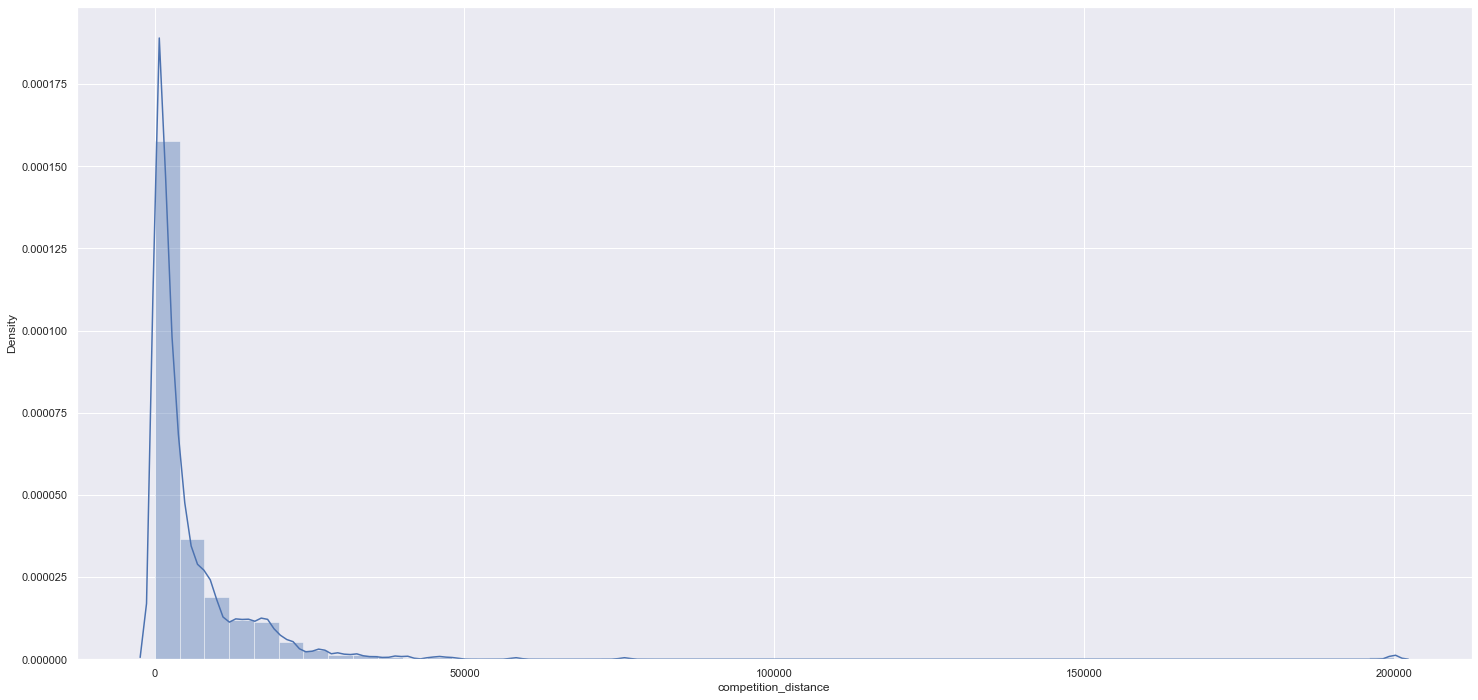

In [22]:
sns.distplot(df1['competition_distance'])

### 1.7.2 - Categorical Attributs

In [23]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

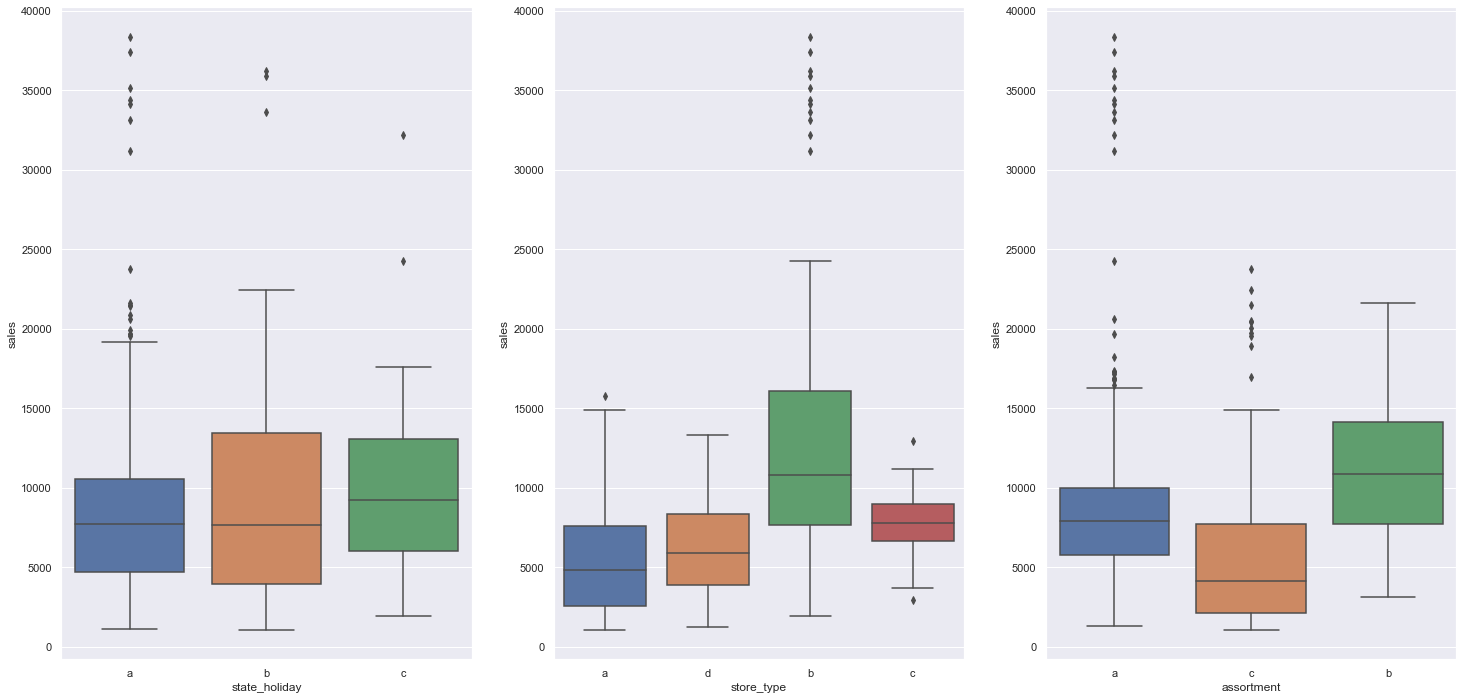

In [24]:
aux1 = df1[(df1['state_holiday'] != '0') &  df1['sales'] > 0]

plt.subplot(1, 3, 1)
sns.boxplot( x='state_holiday', y='sales', data=aux1 )

plt.subplot(1, 3, 2)
sns.boxplot( x='store_type', y='sales', data=aux1 )

plt.subplot(1, 3, 3)
sns.boxplot( x='assortment', y='sales', data=aux1 )

# 2.0 - Passo 2 - Feature Engineering

In [25]:
df2 = df1.copy()

## 2.1 - Mindmap image

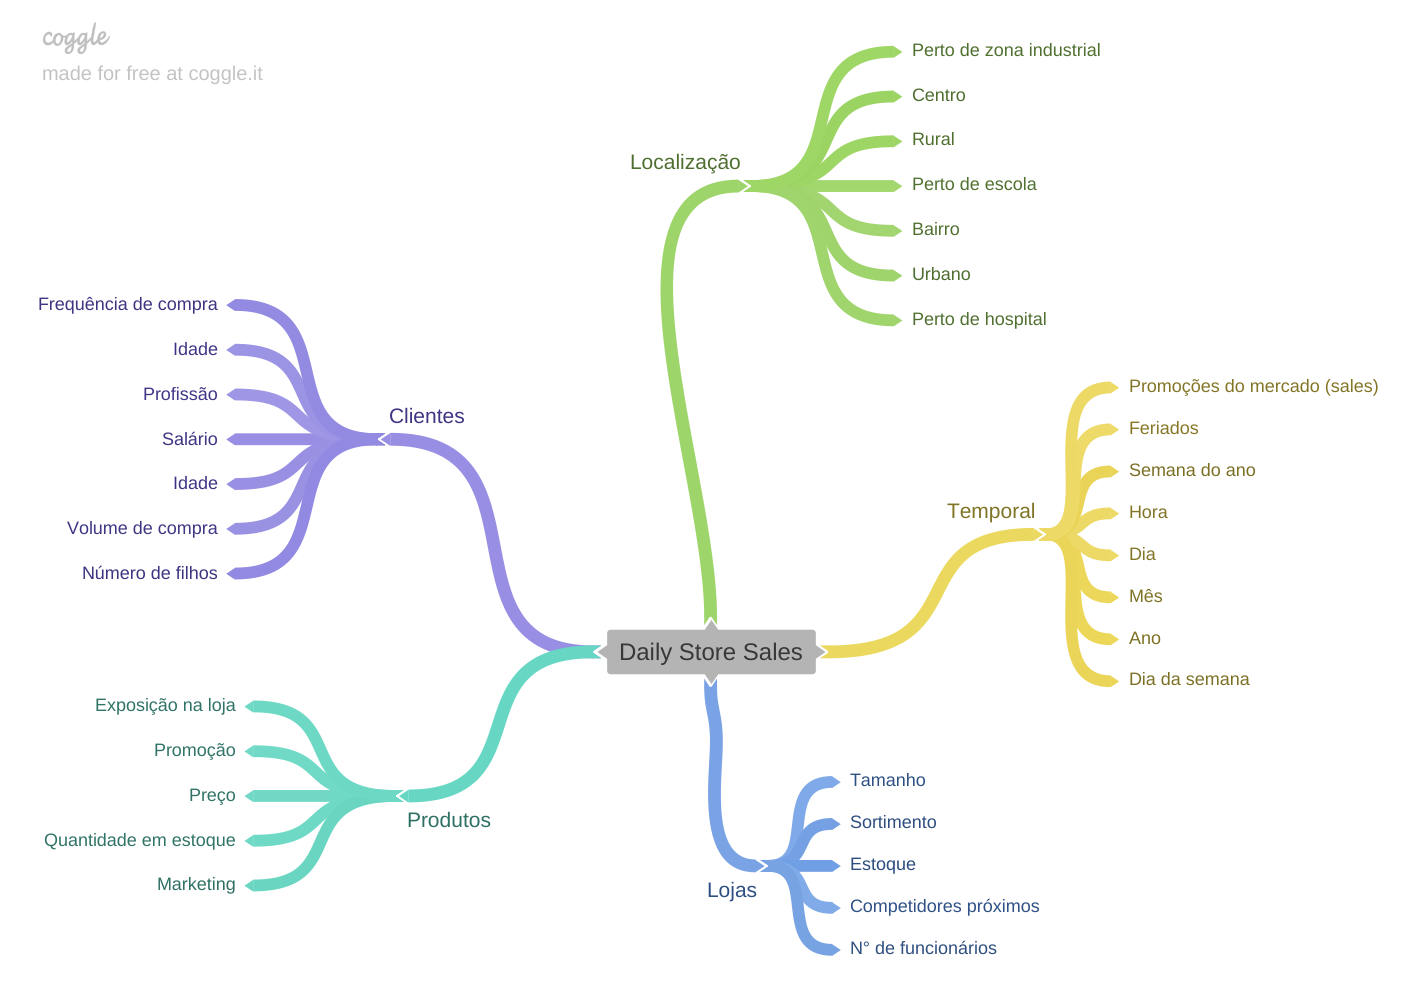

In [26]:
Image('img/Daily_Store_Sales.png')

## 2.2 - Mindmap hypothesis

### 2.1.1 - Store Hypothesis

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

### 2.1.2 - Product Hypothesis

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**4.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.1.3 - Time Hypothesis

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3 - Final Hypothesis List

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.4 - Feature Engineering

In [27]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of the year
df2['week_of_year'] = df2['date'].dt.week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')


# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'],
                                                                 month=x['competition_open_since_month'],
                                                                 day=1), axis = 1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)


# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - 
                                                        datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')


# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' 
                                                  else 'easter_holiday' if x == 'b' 
                                                  else 'christmas_holiday' if x == 'c'
                                                  else 'regular_day')

C:\Users\filip\AppData\Local\Temp\ipykernel_1228\1889290336.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.week


In [28]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 - Passo 3 - Variable Filtering

In [29]:
df3 = df2.copy()

## 3.1 - Filtering the lines

In [30]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 - Selecting the Columns

In [31]:
# Columns that we won't use for the prediction
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0 - Passo 4 - Exploratory Data Analysis

In [32]:
df4 = df3.copy()

## 4.1 - Univariable Analysis

### 4.1.1 - Response Variable

C:\Users\filip\anaconda3\envs\DSemProducao\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

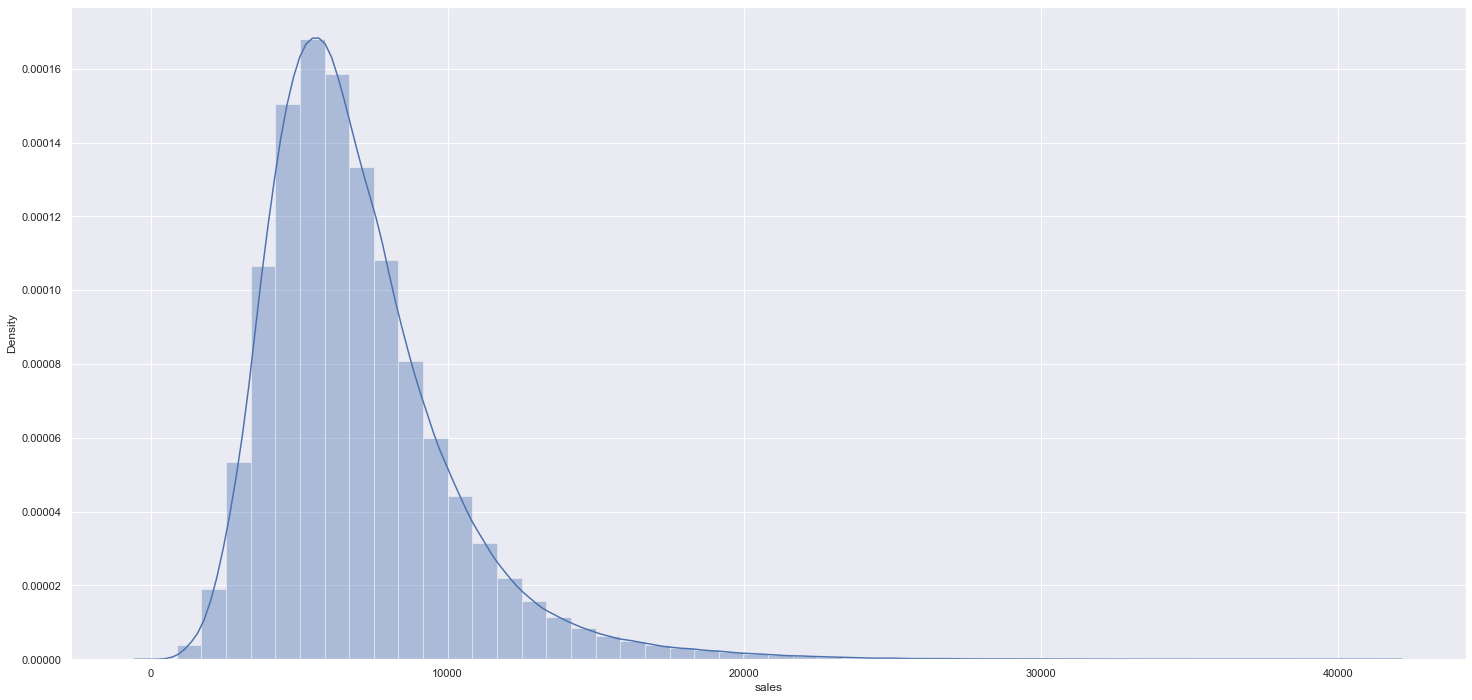

In [33]:
sns.distplot(df4['sales'])

### 4.1.2 - Numerical Variable

array([[<AxesSubplot:title={'center':'store'}>,
        <AxesSubplot:title={'center':'day_of_week'}>,
        <AxesSubplot:title={'center':'sales'}>,
        <AxesSubplot:title={'center':'customers'}>],
       [<AxesSubplot:title={'center':'open'}>,
        <AxesSubplot:title={'center':'promo'}>,
        <AxesSubplot:title={'center':'school_holiday'}>,
        <AxesSubplot:title={'center':'competition_distance'}>],
       [<AxesSubplot:title={'center':'competition_open_since_month'}>,
        <AxesSubplot:title={'center':'competition_open_since_year'}>,
        <AxesSubplot:title={'center':'promo2'}>,
        <AxesSubplot:title={'center':'promo2_since_week'}>],
       [<AxesSubplot:title={'center':'promo2_since_year'}>,
        <AxesSubplot:title={'center':'is_promo'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

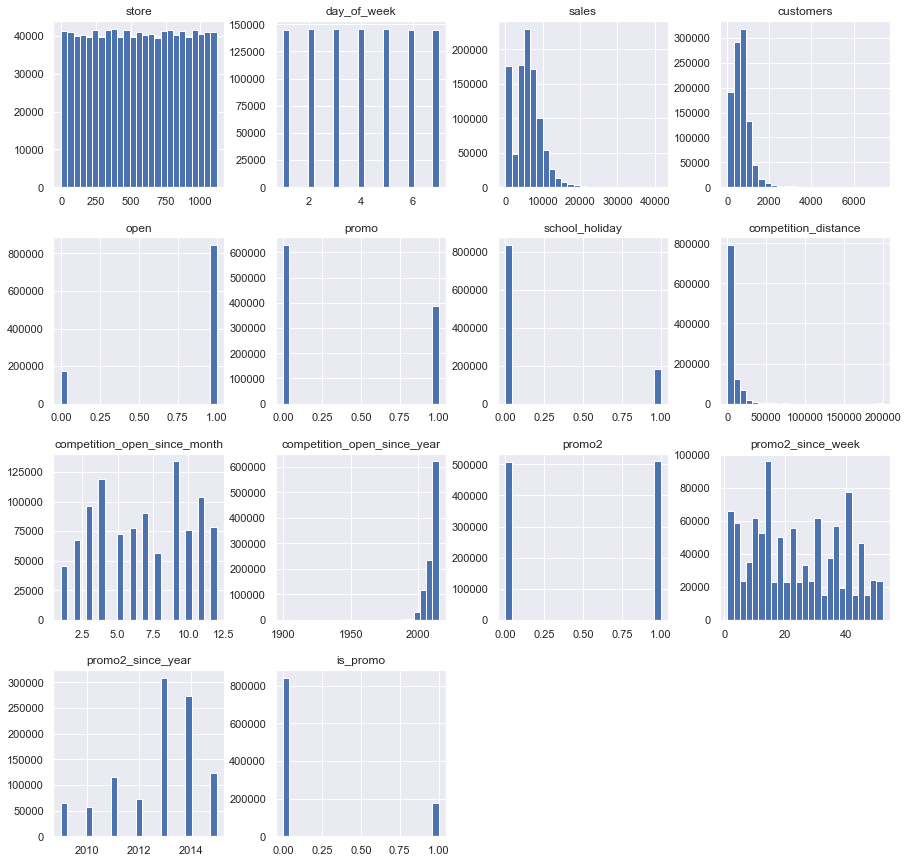

In [34]:
plt.rcParams["figure.figsize"] = (15,15)

num_attributes.hist(bins=25)

### 4.1.3 - Categorical Variable

In [35]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

C:\Users\filip\anaconda3\envs\DSemProducao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\filip\anaconda3\envs\DSemProducao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\filip\anaconda3\envs\DSemProducao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpreta

<AxesSubplot:xlabel='sales', ylabel='Density'>

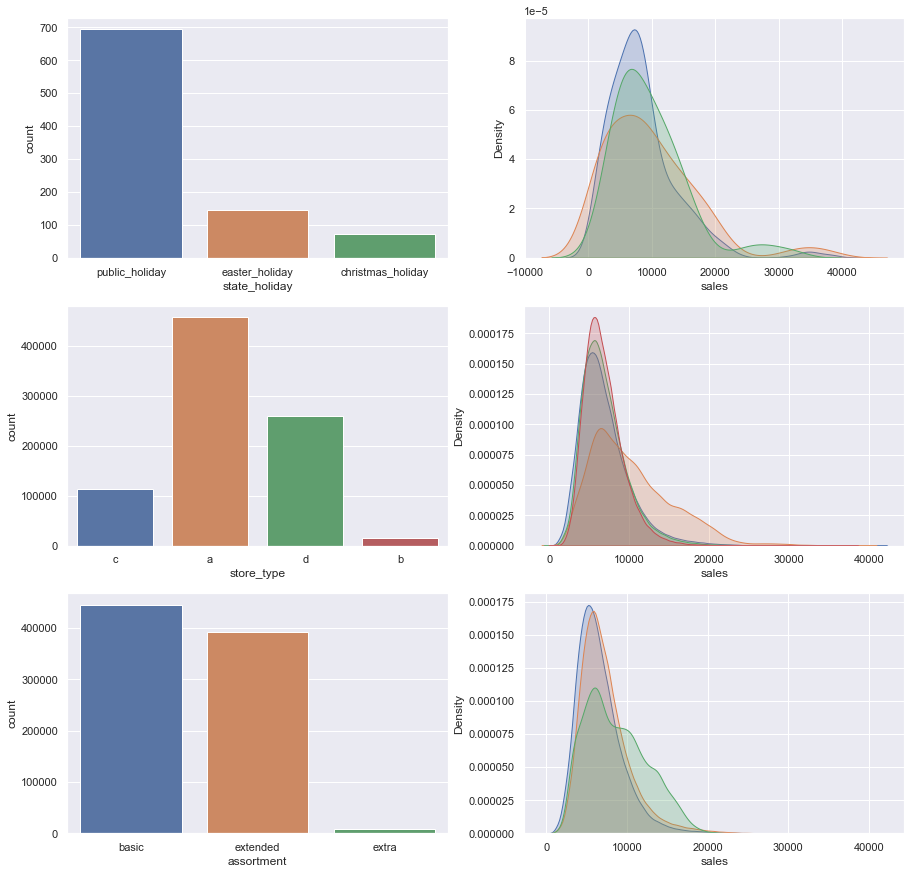

In [36]:
plt.rcParams["figure.figsize"] = (15,15)

# state_holiday
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label ='public_holiday', shade = True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label ='easter_holiday', shade = True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas_holiday']['sales'], label ='christmas_holiday', shade = True)

# store_type
plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label ='a', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label ='b', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label ='c', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label ='d', shade = True)



# assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label ='basic', shade = True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label ='extended', shade = True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label ='extra', shade = True)

## 4.2 - Bivariable Analysis

### **H1.** Lojas com maior sortimentos deveriam vender mais.

**A premissa é falsa!** - Na verdade, lojas com maior sortimento contribuem MENOS para o resultado final da empresa

<AxesSubplot:xlabel='year_week'>

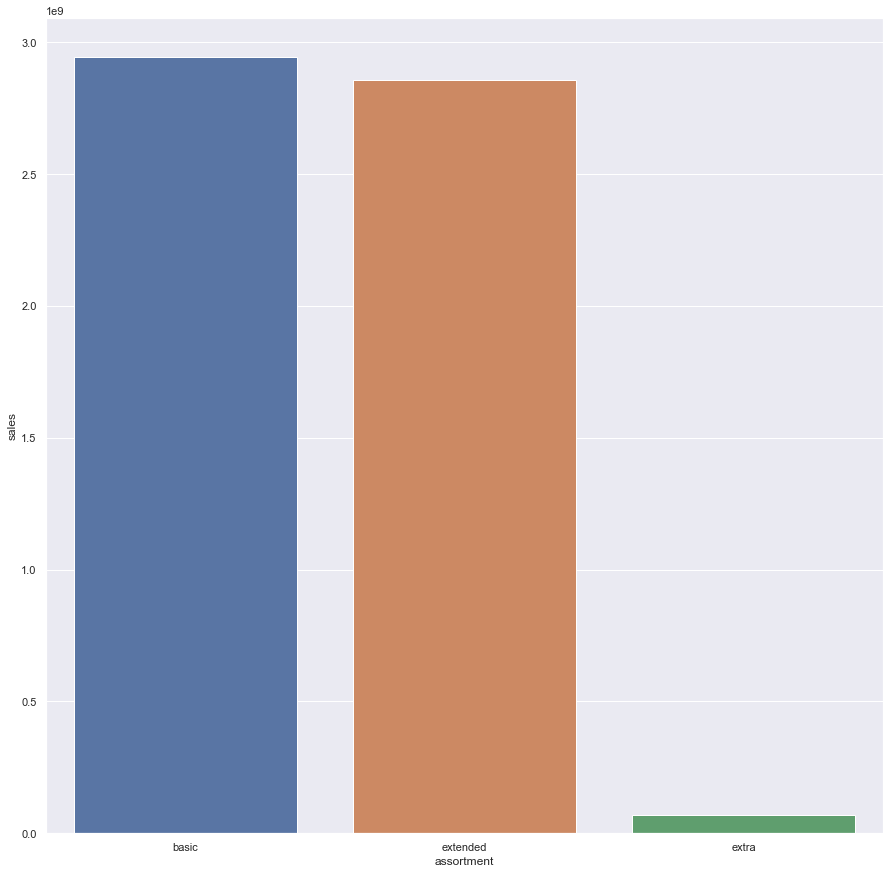

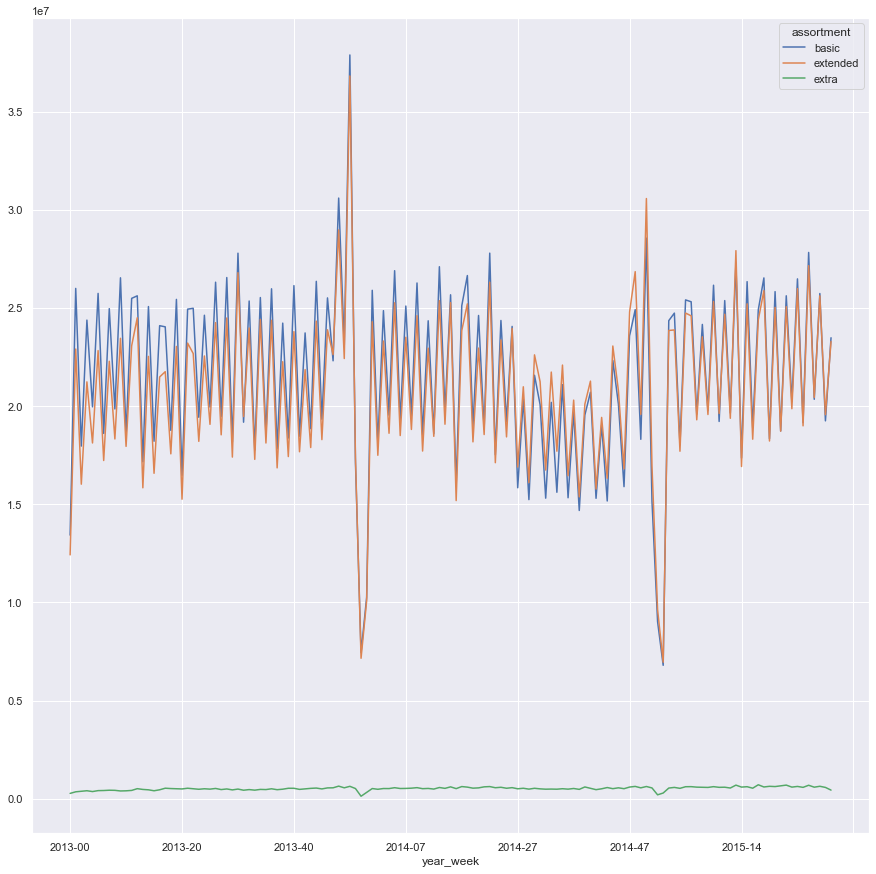

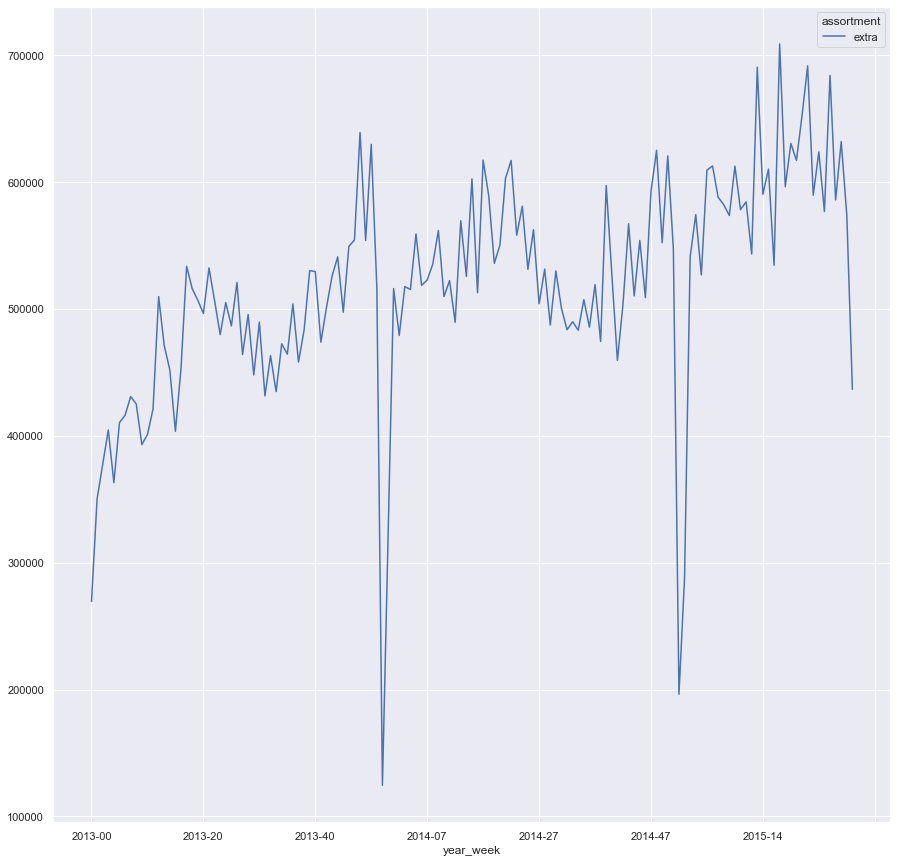

In [37]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x = 'assortment', y = 'sales', data = aux1)

aux2 = df4[['year_week','assortment','sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

### **H2.** Lojas com competidores mais próximos deveriam vender menos.
**A premissa é falsa!** - Como conseguimos ver pelos gráficos abaixo, quanto mais próximo de outras lojas, mais vendemos. O mapa de calor mostra uma correlação modular de .23 entre a distância da competição e o valor de vendas.

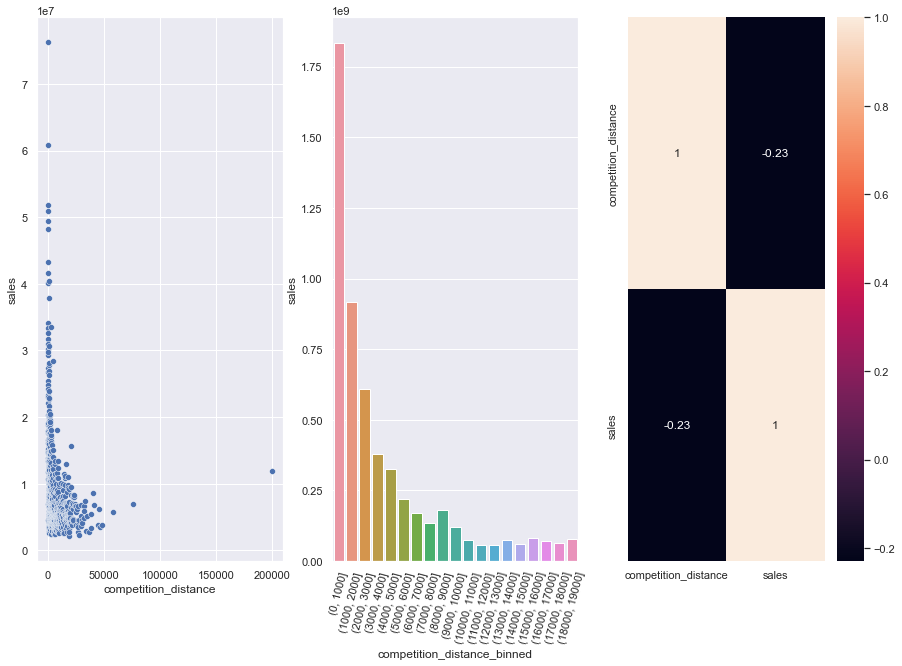

In [38]:
plt.rcParams["figure.figsize"] = (15,10)

aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()
bins = list(np.arange (0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()

plt.subplot(1,3,2)
sns.barplot(x = 'competition_distance_binned', y = 'sales', data = aux2);
plt.xticks(rotation=75);

plt.subplot(1,3,1)
sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H3.** Lojas com competidores à mais tempo deveriam vendem mais.
**A premissa é falsa!** - Segundo os gráficos abaixo, lojas com mais tempo de competição aberta tendem a vender MENOS.


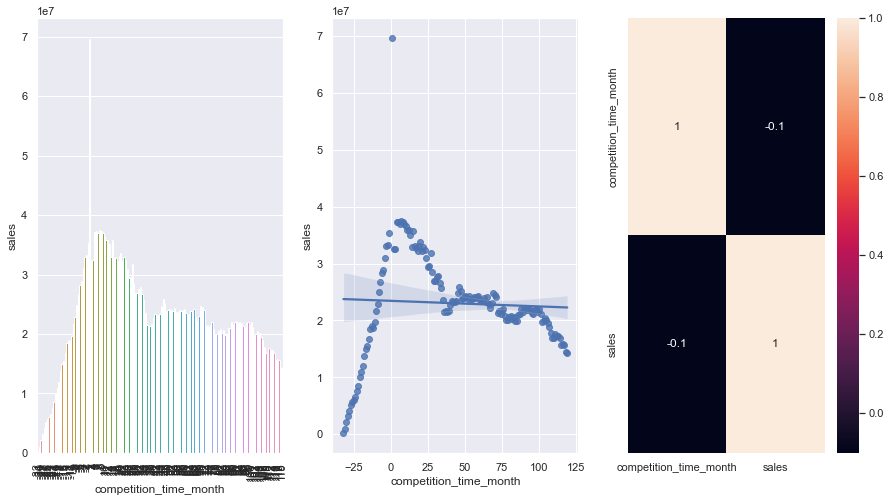

In [39]:
plt.rcParams["figure.figsize"] = (15,8)

plt.subplot(1,3,1)
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x = 'competition_time_month', y = 'sales', data = aux2);
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.regplot(x = 'competition_time_month', y = 'sales', data = aux2);


plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
**Falsa!** - Promoções rolando a mais tempo tendem a diminuir as vendas com o tempo 

In [40]:
df4.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


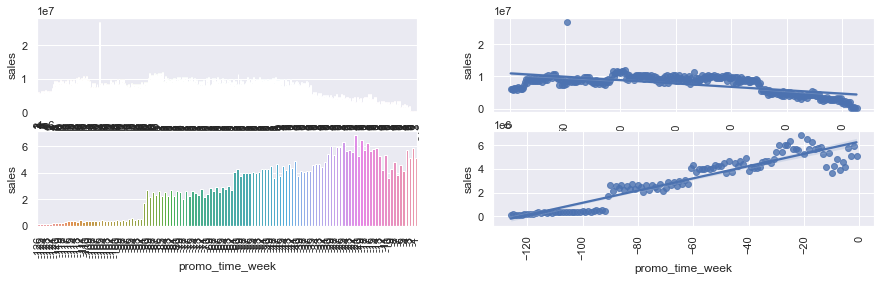

In [41]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
# sns.barplot(x = 'promo_time_week', y = 'sales', data = aux1);

grid = gridspec.GridSpec(4,2)

aux2 = aux1[aux1['promo_time_week'] > 0]  
plt.subplot(grid[0,0])
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux2);
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux2);
plt.xticks(rotation=90);

aux3 = aux1[aux1['promo_time_week'] < 0]
plt.subplot(grid[1,0])
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux3);
plt.xticks(rotation=90);

# plt.subplot(grid[:,2])
# sns.heatmap (aux1.corr(method='pearson'));

# plt.subplot(grid[0,2])
# sns.heatmap (aux2.corr(method='pearson'));

# plt.subplot(grid[1,2])
# sns.heatmap (aux3.corr(method='pearson'));

### <s> **H5.** Lojas com mais dias de promoção deveriam vender mais.</s>

### **H6.** Lojas com mais promoções consecutivas deveriam vender mais.
**Não parece fazer diferença** - elas aparentam ter o mesmo funcionamento

In [42]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


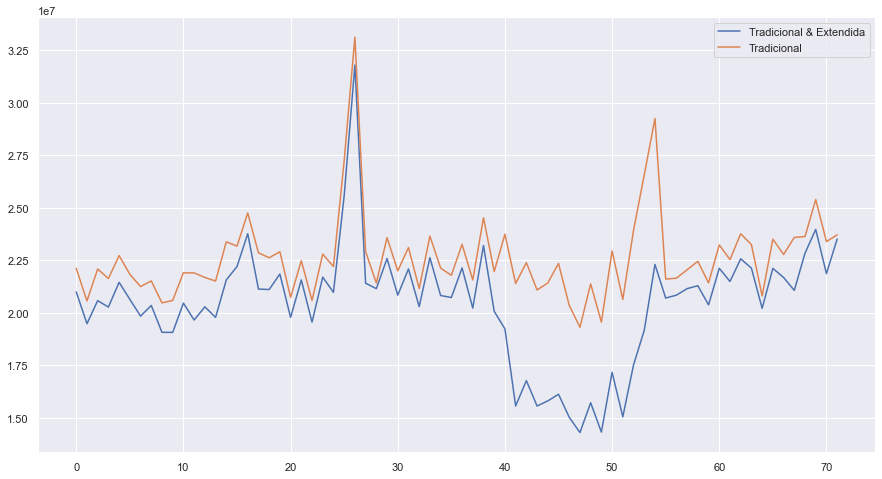

In [43]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week','sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week','sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Tradicional & Extendida', 'Tradicional']);

### H7. Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSA** - Lojas em feriados normais e na páscoa lucram mais 

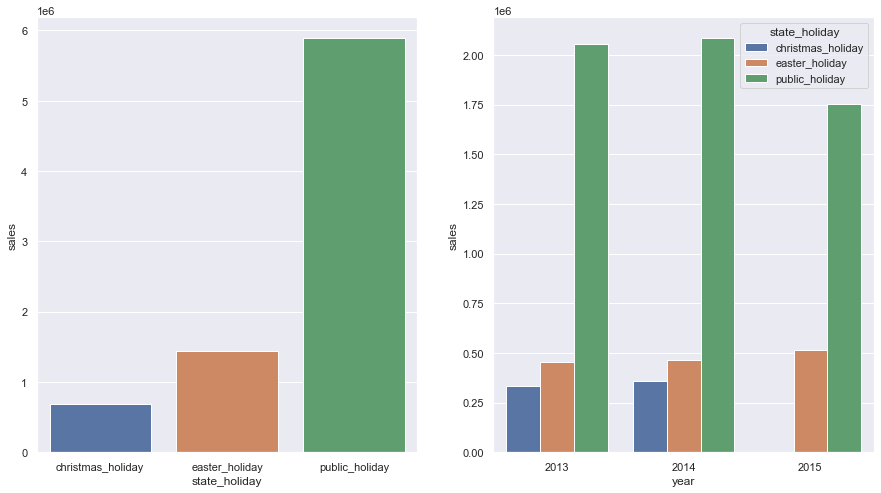

In [44]:
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
plt.subplot(1,2,1)
sns.barplot(x = 'state_holiday', y = 'sales', data = aux1);

aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
plt.subplot(1,2,2)
sns.barplot(x = 'year', y = 'sales', hue='state_holiday', data = aux2);

### H8. Lojas deveriam vender mais ao longo dos anos.
**FALSO**, mas ainda precisamos de mais dados para ver isso, visto que o ano de 2015 ainda não terminou

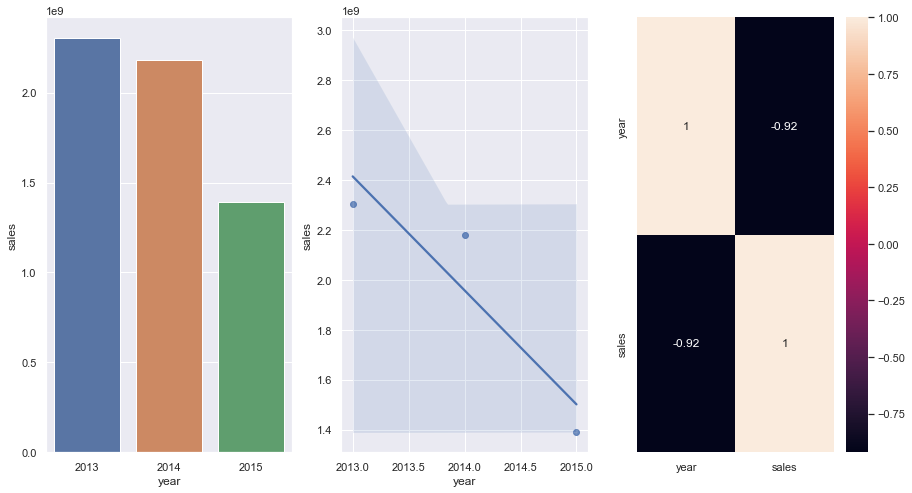

In [45]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
plt.subplot(1,3,1)
sns.barplot(x = 'year', y = 'sales', data = aux1);

plt.subplot(1,3,2)
sns.regplot(x = 'year', y = 'sales', data = aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True);


### H9. Lojas deveriam vender mais no segundo semestre do ano.
**FALSO** Elas vendem menos ao longo do ano

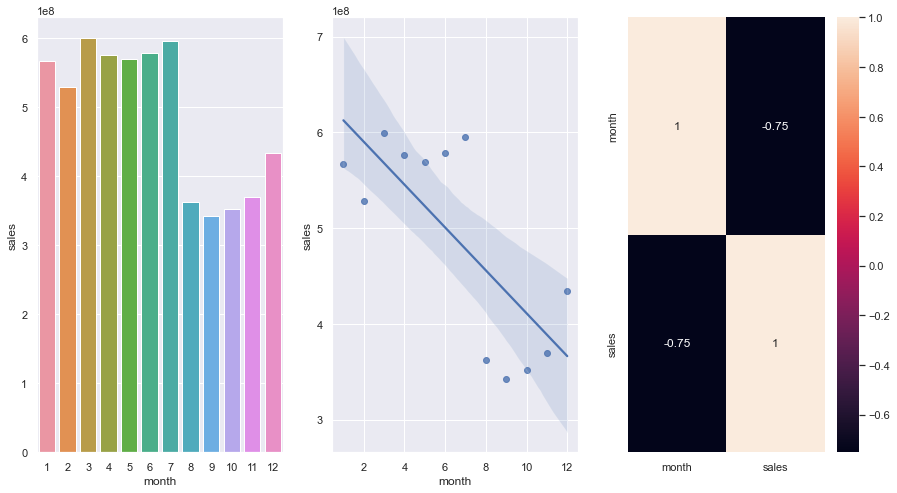

In [46]:
# aux1 = df4[['month','sales']].groupby('month').sum().reset_index()
# aux1 = df4[['month','sales']]


# bins = list(np.arange (0, 13, 6))

# aux1['sales_binned_for_semester'] = pd.cut(aux1['month'], bins=bins)
# aux2 = aux1[['sales_binned_for_semester','sales']].groupby('sales_binned_for_semester').sum().reset_index()
# sns.barplot(x = 'sales_binned_for_semester', y = 'sales', data = aux2)

# aux1['semester'] = 1 if 

aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()
plt.subplot(1,3,1)
sns.barplot(x = 'month', y = 'sales', data = aux1);

plt.subplot(1,3,2)
sns.regplot(x = 'month', y = 'sales', data = aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True);



### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRO** - as pessoas vão gastando menos ao longo dos dias, mas vendem basicamente 2x mais nos 20 últimos dias que nos primieros 10

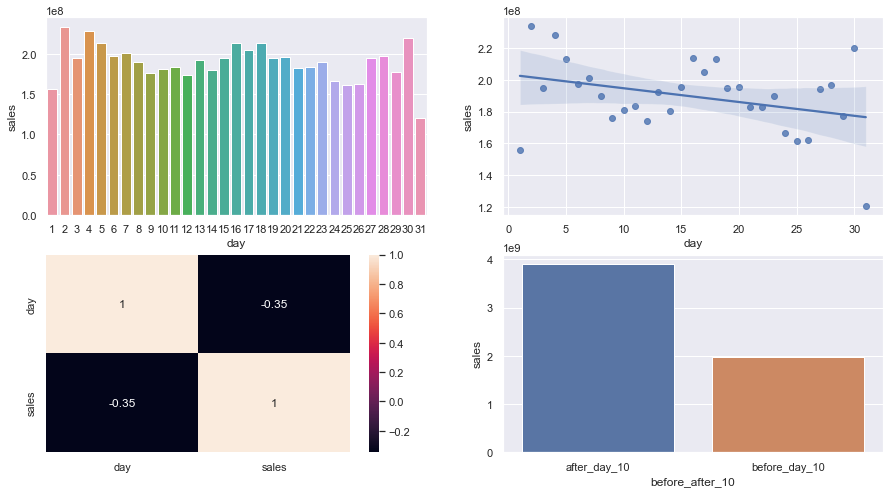

In [47]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()
plt.subplot(2,2,1)
sns.barplot(x = 'day', y = 'sales', data = aux1);

plt.subplot(2,2,2)
sns.regplot(x = 'day', y = 'sales', data = aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True);

aux1['before_after_10'] = aux1['day'].apply(lambda x: 'before_day_10' if x <= 10 else 'after_day_10')
aux2 = aux1[['before_after_10', 'sales']].groupby('before_after_10').sum().reset_index()
plt.subplot(2,2,4)
sns.barplot(x = 'before_after_10', y = 'sales', data = aux2);



### H11. Lojas deveriam vender menos aos finais de semana.
**VERDADEIRO**, mas no sábado vende quase o mesmo tanto que nos outros dias da semana, só no domingo que vende MUITO menos

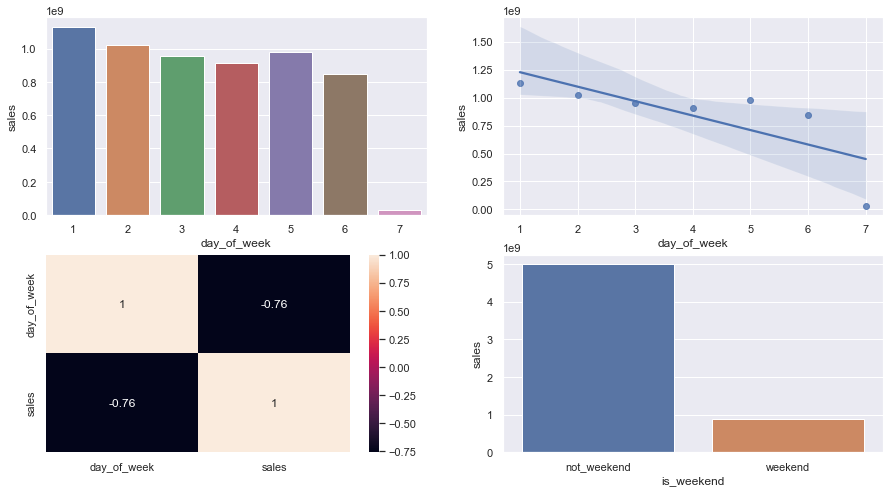

In [48]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x = 'day_of_week', y = 'sales', data = aux1);

plt.subplot(2,2,2)
sns.regplot(x = 'day_of_week', y = 'sales', data = aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True);

aux1['is_weekend'] = aux1['day_of_week'].apply(lambda x: 'not_weekend' if x <= 5 else 'weekend' )
aux2 = aux1[['is_weekend', 'sales']].groupby('is_weekend').sum().reset_index()
plt.subplot(2,2,4)
sns.barplot(x = 'is_weekend', y = 'sales', data = aux2);

### H12. Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRO** - Mas nos meses 7 temos quase o mesmo tanto de vendas em school holiday ou não e mais no mês 8

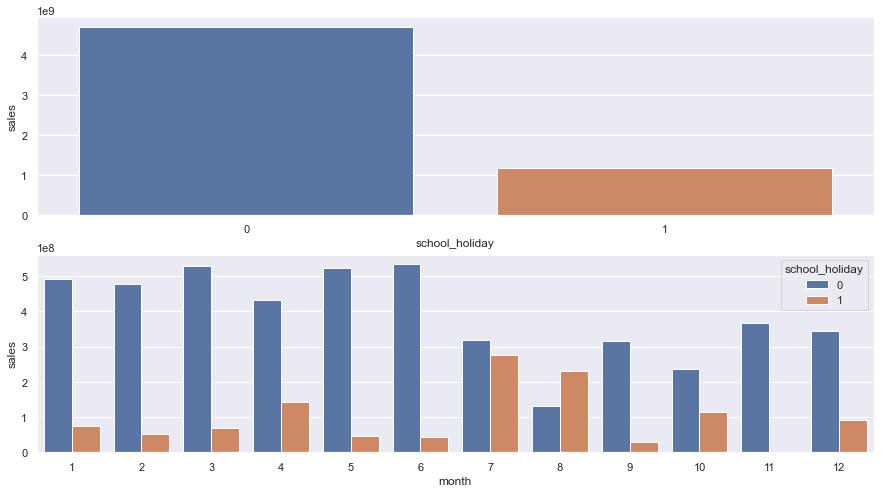

In [49]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2,1,1)
sns.barplot(x = 'school_holiday', y = 'sales', data = aux1);

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot(x = 'month', y = 'sales', hue='school_holiday', data = aux2);


## 4.3 - Multivariable Analysis

### 4.3.1 - Numerical Attributes

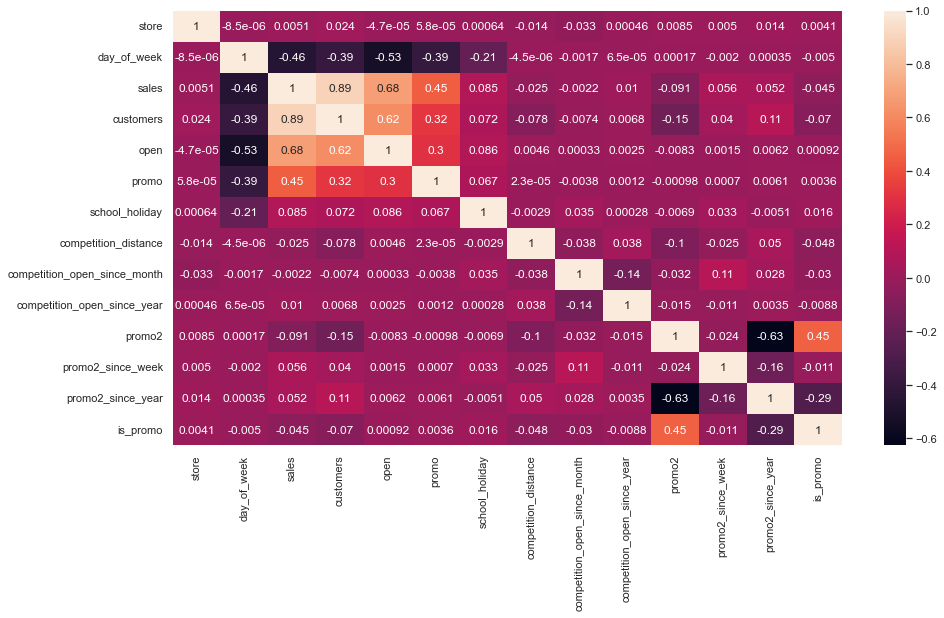

In [50]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap (correlation, annot=True);

### 4.3.2 - Categorical Attributes

In [51]:
a = df4.select_dtypes(include='object')
a.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


In [52]:
# Crámer's V Calculation
def cramer_v (x, y):
    cm = pd.crosstab(x, y).values    
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))


In [53]:
cramer_v(a['state_holiday'], a['store_type'])

0.07106469715258833

In [54]:
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

d = pd.DataFrame({'state_holiday': [a1,a2,a3],
              'store_type': [a4,a5,a6],
              'assortment': [a7,a8,a9]})

d = d.set_index(d.columns)

<AxesSubplot:>

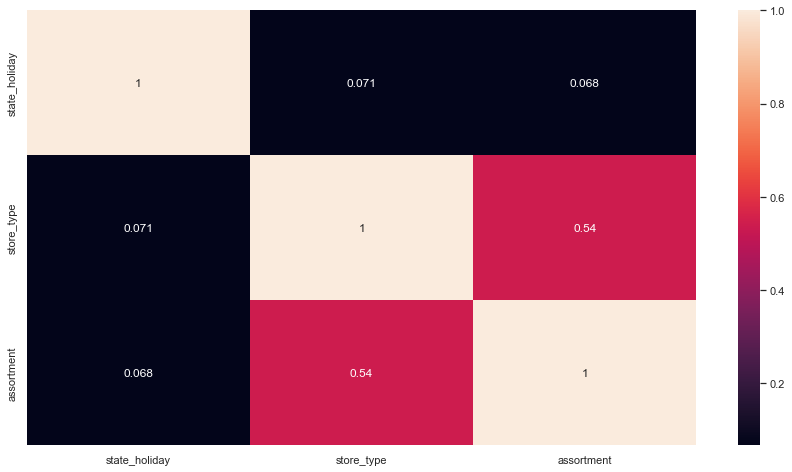

In [55]:
sns.heatmap(d, annot=True)

# 5.0 - Passo 5 - Data Preparation

In [56]:
df5 = df4.copy()

## 5.1 - Normalizing

We shuold be normalizing the Gaussian data, but we're not going to do antyhing because there are no Gaussian features

## 5.2 - Rescaling

The idea is to make all numerical features equaly important to the algorithm.

Abaixo a formula para fazer o rescaling normalizando e normalizando levando em consideração os quartis:

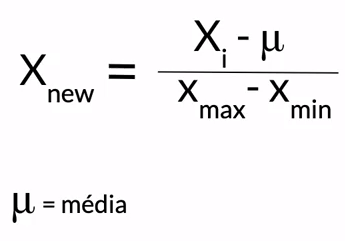

In [57]:
Image('img/Rescaling.PNG')

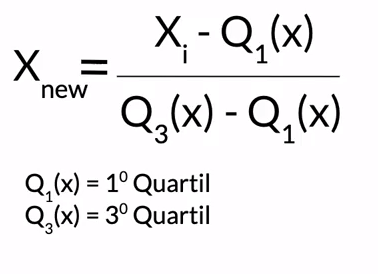

In [58]:
Image('img/Robust_rescaling.PNG')

In [59]:
a = df5.select_dtypes(include=['int64', 'int32', 'float64'])

In [60]:
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,4,0


In [61]:
## NON CICLICAL FEATURES
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

# year
df5['year'] = mms.fit_transform(df5[['year']].values)


## CICLICAL FEATURES
# month
# day
# week of year
# day of week

## 5.3 - Transforming the data

### 5.3.1 - Encoding

In [62]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix = 'state_holiday', columns = ['state_holiday'])

In [63]:
# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

In [64]:
# assortment - Ordinal Encoding
assortment_dict = {'basic': 1,
                   'extra': 2,
                   'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 - Response Variable Transformation 

In [65]:
df5.sales = np.log1p(df5['sales'])

### 5.3.3 - Transforming the nature of the data
The idea behind this step is to bring your data the closest possible to a normal distribution

In [66]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * ( 2 * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * ( 2 * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin( x * ( 2 * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x * ( 2 * np.pi/12 ) ) )

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin( x * ( 2 * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply(lambda x: np.cos( x * ( 2 * np.pi/30 ) ) )

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x * ( 2 * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x * ( 2 * np.pi/52 ) ) )

In [67]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas_holiday,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


# 6.0 - Passo 06 - Feature Selection

In [68]:
df6 = df5.copy()

## 6.1 - Split dataframe into training and test dataset 

In [69]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop( cols_drop, axis=1)

In [70]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days = 7*6)

Timestamp('2015-06-19 00:00:00')

In [71]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training min date: {}'.format(X_train['date'].min()))
print('Training max date: {}'.format(X_train['date'].max()))

print('\nTest min date: {}'.format(X_test['date'].min()))
print('Test max date: {}'.format(X_test['date'].max()))

Training min date: 2013-01-01 00:00:00
Training max date: 2015-06-18 00:00:00

Test min date: 2015-06-19 00:00:00
Test max date: 2015-07-31 00:00:00


## 6.2 - Boruta as Feature Selector

In [72]:
### IMPORTANTE NÃO DESLIGAR O NOTEBOOK ATÉ TERMINAR O MÓDULO. DEMOROU 2H10 PARA RODAR ESSE SCRIPT

# training and test dataset for Boruta
# X_train_n = X_train.drop(['date', 'sales'], axis=1).values
# y_train_n = y_train.values.ravel()


# define RandomForestRegressor
# rf = RandomForestRegressor (n_jobs = -1)

#define Boruta
# boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit( X_train_n, y_train_n)


### 6.2.1 - Best Features From Boruta

In [73]:
### cell added to run without running boruta again


X_train_n = X_train.drop(['date', 'sales'], axis=1).values
y_train_n = y_train.values.ravel()


boruta = ['store',
          'promo',
          'store_type',
          'assortment',
          'competition_distance',
          'competition_open_since_month',
          'competition_open_since_year',
          'promo2',
          'promo2_since_week',
          'promo2_since_year',
          'competition_time_month',
          'promo_time_week',
          'day_of_week_sin',
          'day_of_week_cos',
          'month_cos',
          'day_sin',
          'day_cos',
          'week_of_year_cos']

In [74]:
cols_selected = boruta

# best features
X_train_fs = X_train.drop(['date', 'sales'], axis=1)    
cols_selected_boruta = X_train_fs.loc[:, cols_selected].columns.to_list()

# cols not selected by boruta
cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

In [75]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos']

In [76]:
# IREMOS USAR TAMBÉM O MONTH_SIN, O WEEK_OF_YEAR_SIN E O YEAR PARA O MODELEO

cols_not_selected_boruta

['is_promo',
 'month_sin',
 'school_holiday',
 'state_holiday_christmas_holiday',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'week_of_year_sin',
 'year']

## 6.3 - Manual Feature Selection

In [77]:
cols_selected_boruta = ['store',
                        'promo',
                        'store_type',
                         'assortment',
                         'competition_distance',
                         'competition_open_since_month',
                         'competition_open_since_year',
                         'promo2',
                         'promo2_since_week',
                         'promo2_since_year',
                         'competition_time_month',
                         'promo_time_week',
                         'day_of_week_sin',
                         'day_of_week_cos',
                         'month_sin',
                         'month_cos',
                         'day_sin',
                         'day_cos',
                         'week_of_year_sin',
                         'week_of_year_cos',
                         'year']

# columns to add
feat_to_add = ['date', 'sales']

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

In [78]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'year']

# 7 - Passo  07 - Machine Learning Modelling

In [79]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series Data Prep
x_training = X_train[cols_selected_boruta_full]

## 7.1 - Average model

O modelo de média é o modelo mais simples que existe e é usado para servir de baseline para o resto dos modelos

In [80]:
def mean_absolute_percentage_error(y, yhat):
    return np.mean( np.abs( ( y - yhat ) / y ) )

In [81]:
def ml_error(model_name, y, yhat):
    mae = mean_absolute_error (y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt( mean_squared_error(y, yhat) )
    
    return pd.DataFrame( { 'Model Name': model_name,
                           'MAE': mae,
                           'MAPE': mape,
                           'RMSE': rmse}, index=[0] )

In [82]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# using the mean average as the prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']


# performance - using expm1 in account of transforming the data to a log in the section 5.3.2
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2 - Linear Regression

A ideia de usar a regressão linear e a regressão linear regularizada é para verificar se o nosso modelo segue uma distribuição normal e pode ser tratado como tal.

In [83]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)


# performance
lr_result = ml_error('Linear Regressor', np.expm1( y_test ), np.expm1( yhat_lr ) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regressor,1864.174592,0.286109,2692.723297


### 7.2.1 - Linear Regression - Cross Validation

In [84]:
lr_result_cv = cross_validation ('Linear Regression', lr, x_training, 5, verbose=False)

## 7.3 - Linear Regression Regularized - Lasso

In [85]:
# model
lrr = Lasso( alpha=0.01 ).fit(x_train, y_train)

# prediction
yhat_lrr = lr.predict(x_test)


# performance
lrr_result = ml_error('Linear Regressor Regularized - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regressor Regularized - Lasso,1867.720626,0.283808,2707.125259


### 7.3.1 - Linear Regression Regularized - Cross Validation

In [86]:
lrr_result_cv = cross_validation ('Lasso', lrr, x_training, 5, verbose=False)

In [87]:
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4 - Random Forest Regressor

Non linear Machine Learning Model - Como podemos ver comparando a baseline com o resultado de erro dos modelos lineares, se trata de um grupo que não se dá bem com modelos lineares.

In [88]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=1, random_state=4242 ).fit(x_train, y_train)

# prediction
yhat_rf = rf.predict(x_test)


# performance
rf_result = ml_error('Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,682.920886,0.100567,1015.383487


### 7.4.1 - Random Forest Regressor - Cross Validation

In [94]:
rf_result_cv = cross_validation ('Random Forest Regressor', rf, x_training, 5, verbose=True)


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


In [95]:
rf_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,838.29 +/- 218.21,0.12 +/- 0.02,1257.25 +/- 318.84


## 7.5 - XGBoost Regressor

In [78]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100,
                              learning_rate=0.01,
                              max_depth=10,
                              subsample=0.7,
                              colsample_bytree=0.9 ).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )


# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

######### POR ALGUM MOTIVO O RESULTADO DO GXBOOST FICOU UM LIXO. TENTAR ENTENDER DEPOIS #########

C:\Users\filip\anaconda3\envs\DSemProducao\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6683.473624,0.94941,7330.955863


### 7.5.1 - XGBoost Regressor - Cross Validation

In [96]:
xgb_result_cv = cross_validation ('XGBoost Regressor', model_xgb, x_training, 5, verbose=True)


KFold Number: 5


C:\Users\filip\anaconda3\envs\DSemProducao\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number: 4


C:\Users\filip\anaconda3\envs\DSemProducao\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number: 3


C:\Users\filip\anaconda3\envs\DSemProducao\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number: 2


C:\Users\filip\anaconda3\envs\DSemProducao\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number: 1


C:\Users\filip\anaconda3\envs\DSemProducao\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [97]:
xgb_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7049.48 +/- 588.84,0.95 +/- 0.0,7715.63 +/- 689.66


## 7.6 - Comparing Model's Performance

### 7.6.1 - Single performance

In [79]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result ])
modelling_result.sort_values( 'RMSE' ).reset_index()

,index,Model Name,MAE,MAPE,RMSE
0,0,Random Forest Regressor,682.920886,0.100567,1015.383487
1,0,Average Model,1354.800353,0.455051,1835.135542
2,0,Linear Regressor,1864.174592,0.286109,2692.723297
3,0,Linear Regressor Regularized - Lasso,1864.174592,0.286109,2692.723297
4,0,XGBoost Regressor,6683.473624,0.949410,7330.955863


### 7.6.2 - Cross Validation

In [99]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv ])
print(modelling_result_cv)

                Model Name              MAE CV        MAPE CV  \
0        Linear Regression  2040.85 +/- 268.55   0.3 +/- 0.01   
0                    Lasso   2116.38 +/- 341.5  0.29 +/- 0.01   
0  Random Forest Regressor   838.29 +/- 218.21  0.12 +/- 0.02   
0        XGBoost Regressor  7049.48 +/- 588.84   0.95 +/- 0.0   

              RMSE CV  
0   2914.94 +/- 398.8  
0  3057.75 +/- 504.26  
0  1257.25 +/- 318.84  
0  7715.63 +/- 689.66  


# 9 - Passo 09 - Describing the error 

In [108]:
df9 = X_test[ cols_selected_boruta_full ]

# rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_rf )

df9.head()


C:\Users\filip\AppData\Local\Temp\ipykernel_1228\1914595690.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['sales'] = np.expm1( df9['sales'] )
C:\Users\filip\AppData\Local\Temp\ipykernel_1228\1914595690.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['predictions'] = np.expm1( yhat_rf )


,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_time_month,promo_time_week,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,year,date,sales,predictions
0,1,1,2,1,-0.170968,9,2008,0,31,2015,0.918919,0.287016,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,1.0,2015-07-31,5263.0,5420.377291
1,2,1,0,1,-0.283871,11,2007,1,13,2010,1.054054,0.922551,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,1.0,2015-07-31,6064.0,6397.797776
2,3,1,0,1,1.903226,12,2006,1,14,2011,1.202703,0.801822,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,1.0,2015-07-31,8314.0,9398.105579
3,4,1,2,3,-0.275806,9,2009,0,31,2015,0.743243,0.287016,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,1.0,2015-07-31,13995.0,11841.442810
4,5,1,0,1,4.448387,4,2015,0,31,2015,-0.162162,0.287016,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,1.0,2015-07-31,4822.0,5875.001116


## 9.1 - Business Performance

In [123]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename(columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename(columns={0:'MAPE'})

# merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

# scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# reordering columns 
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [133]:
df92.sort_values('MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,109243.954276,105648.921766,112838.986787,3595.032511,0.617772
908,909,248253.389728,241123.419330,255383.360126,7129.970398,0.497790
549,550,260336.625509,258499.230225,262174.020793,1837.395284,0.369695
875,876,212578.402451,208690.575886,216466.229016,3887.826565,0.300126
182,183,213107.540380,211323.836094,214891.244667,1783.704287,0.292419


<AxesSubplot:xlabel='store', ylabel='MAPE'>

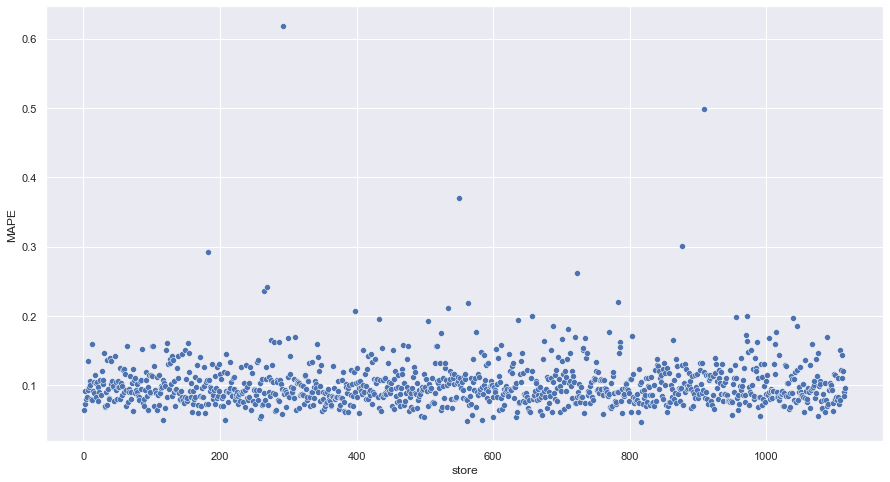

In [134]:
sns.scatterplot(x='store', y='MAPE', data=df92)

## 9.2 - Total Performance

In [138]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0: 'Values' } )
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )

df93.head()

,Scenario,Values
0,predictions,"R$289,511,020.31"
1,worst_scenario,"R$288,745,883.00"
2,best_scenario,"R$290,276,157.62"


## 9.3 - Macinhe Learning Performance 

In [139]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

C:\Users\filip\AppData\Local\Temp\ipykernel_1228\1385645114.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error'] = df9['sales'] - df9['predictions']
C:\Users\filip\AppData\Local\Temp\ipykernel_1228\1385645114.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error_rate'] = df9['predictions'] / df9['sales']


C:\Users\filip\anaconda3\envs\DSemProducao\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\filip\anaconda3\envs\DSemProducao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='predictions', ylabel='error'>

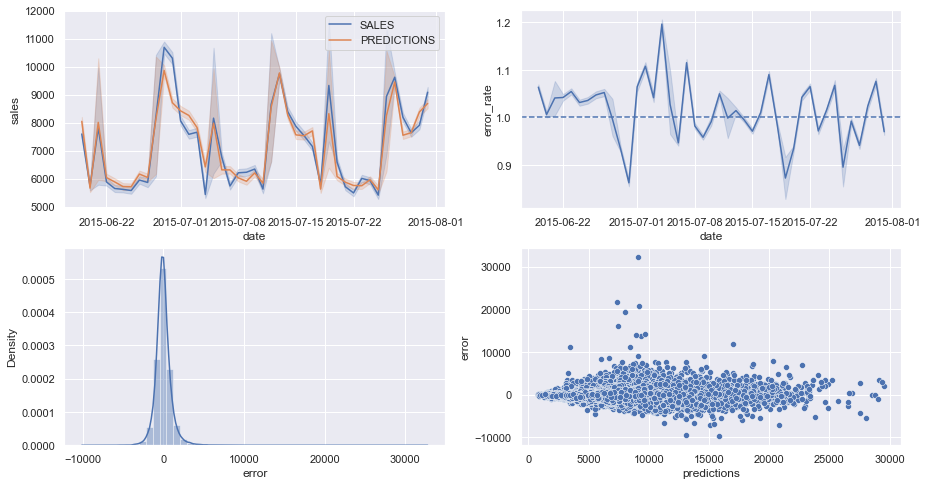

In [144]:
plt.subplot(2,2,1)
sns.lineplot( x='date', y='sales', data=df9, label = 'SALES')
sns.lineplot( x='date', y='predictions', data=df9, label = 'PREDICTIONS')

plt.subplot(2,2,2)
sns.lineplot( x='date', y='error_rate', data=df9)
plt.axhline(1, linestyle = '--')

plt.subplot(2,2,3)
sns.distplot( df9['error'] )

plt.subplot(2,2,4)
sns.scatterplot( df9['predictions'], df9['error'])